In [ ]:
import os
import pickle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np

import matplotlib.pyplot as plt
from collections import Counter
# import tifffile as tiff

In [2]:
# Function to load data from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'rb') as f:
            image, label = pickle.load(f)
            # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
            image = np.transpose(image, (1, 2, 0))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Paths to your data directories
train_dir = "data/classification_dataset/train"
validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# Load the data
train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)

# Convert data to tf.data.Dataset
def create_tf_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

train_dataset = create_tf_dataset(train_images, train_labels)
validation_dataset = create_tf_dataset(val_images, val_labels)
test_dataset = create_tf_dataset(test_images, test_labels)

# Batch and shuffle the datasets
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



(32, 32, 12) 0


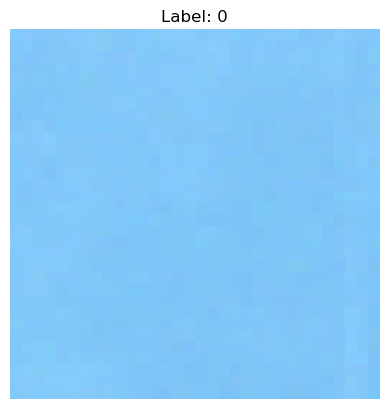

In [3]:
for images, labels in train_dataset.take(1):
    for i in range(1):
        print(images[i].shape, labels[i].numpy())
        image = images[i]
        label = labels[i]

        # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
        #image = np.transpose(image, (1, 2, 0))  # (12, 32, 32) -> (32, 32, 12)

        # Select RGB bands (e.g., bands 4, 3, 2 from Sentinel-2, adjust if needed)
        rgb_image = np.stack([
            image[:, :, 3],  # Band 4 (Red)
            image[:, :, 2],  # Band 3 (Green)
            image[:, :, 1]   # Band 2 (Blue)
        ], axis=-1)
        
        # Normalize the RGB image for saving
        rgb_image = (rgb_image / np.max(rgb_image) * 255).astype(np.uint8)

        # Save the image as a TIFF file
        # tiff.imwrite('rgb_image.tiff', rgb_image)
        # print("Image saved as 'rgb_image.tiff'")

        # Display the RGB image
        plt.imshow(rgb_image)
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
        plt.show()


In [4]:
#Use class weights in model to re-balance the data

In [4]:
#Size of training data
for image_batch, labels_batch in train_dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 32, 32, 12)
(32,)


In [6]:
TARGET_SHAPE = (-1, 32, 32,12)

def reshape_tensors(image_batch, labels_batch):
    image_batch = tf.reshape(image_batch, shape=TARGET_SHAPE)
    return image_batch, labels_batch

#train_dataset = train_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)
#validation_dataset = validation_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)
#test_dataset = test_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)


In [7]:
for image_batch, labels_batch in train_dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 32, 32, 12)
(32,)


In [5]:
img_height = 32
img_width = 32

In [6]:
batch_size = 32

In [8]:
num_classes = 2

model = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  layers.Conv2D(16, 12, padding='same', activation='relu', input_shape=(32, 32, 12)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
#model.summary()

In [12]:
#Input to reshape is a tensor with 380928 values, but the requested shape has 393216

test = 380928/(32*32*12)
print(test)

31.0


In [13]:
tf.get_logger().setLevel('ERROR')

In [14]:
epochs=10
history_without_weights = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

#no_classweights_10_ephocs

Epoch 1/10


2024-12-13 10:08:06.011621: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1673/1673 [==============================] - 133s 79ms/step - loss: 0.2841 - accuracy: 0.8569 - val_loss: 0.4920 - val_accuracy: 0.6754
Epoch 2/10
1673/1673 [==============================] - 138s 82ms/step - loss: 0.2355 - accuracy: 0.8868 - val_loss: 0.3978 - val_accuracy: 0.7831
Epoch 3/10
1673/1673 [==============================] - 139s 83ms/step - loss: 0.2093 - accuracy: 0.8987 - val_loss: 0.4546 - val_accuracy: 0.7543
Epoch 4/10
1673/1673 [==============================] - 228s 136ms/step - loss: 0.2028 - accuracy: 0.9023 - val_loss: 0.4944 - val_accuracy: 0.6798
Epoch 5/10
1673/1673 [==============================] - 150s 90ms/step - loss: 0.2003 - accuracy: 0.9035 - val_loss: 0.4452 - val_accuracy: 0.7895
Epoch 6/10
1673/1673 [==============================] - 165s 99ms/step - loss: 0.1883 - accuracy: 0.9102 - val_loss: 0.3314 - val_accuracy: 0.8566
Epoch 7/10
1673/1673 [==============================] - 158s 94ms/step - loss: 0.1820 - accuracy: 0.9140 - val_loss: 0.3742 - va

In [37]:
# Save the entire model as a `.keras` zip archive.
model.save('no_classweights_10_epochs_augmentation_more.keras')

In [38]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

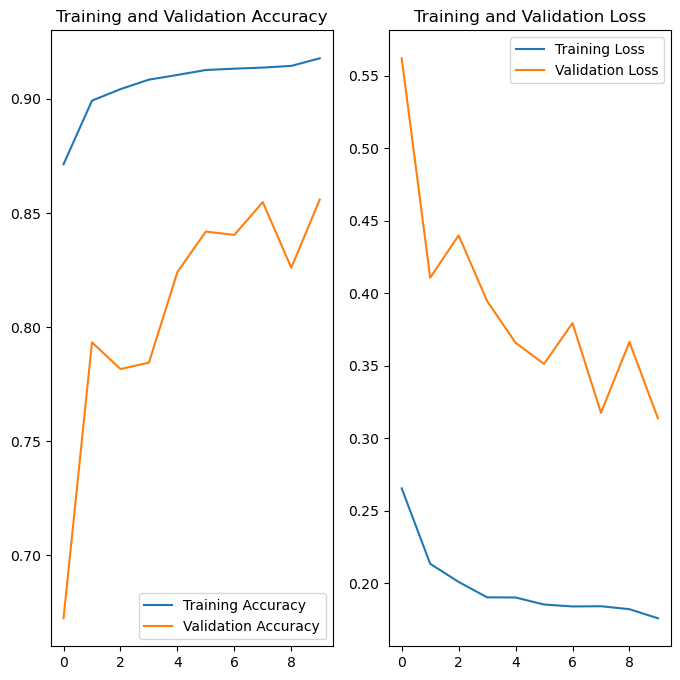

In [39]:
plot_results(history_without_weights)

## Training with class weights

In [40]:
def calculate_class_weights(dataset):
    # Extract all labels from the dataset
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(labels.numpy())

    # Count the occurrences of each class
    label_counts = Counter(all_labels)

    # Total number of samples
    total_samples = sum(label_counts.values())

    # Calculate weights for each class
    class_weights = {label: total_samples / (len(label_counts) * count) 
                     for label, count in label_counts.items()}

    return class_weights

# Calculate class weights for the train_dataset
class_weights = calculate_class_weights(train_dataset)
print("Class Weights:", class_weights)

Class Weights: {0: 0.5864792620670012, 1: 3.390866480871548}


In [41]:
epochs=10
history_model_weights = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  class_weight = class_weights
)

Epoch 1/10
1673/1673 [==============================] - 161s 94ms/step - loss: 0.2609 - accuracy: 0.8605 - val_loss: 0.2374 - val_accuracy: 0.9008
Epoch 2/10
1673/1673 [==============================] - 172s 103ms/step - loss: 0.2368 - accuracy: 0.8718 - val_loss: 0.2270 - val_accuracy: 0.9090
Epoch 3/10
1673/1673 [==============================] - 179s 107ms/step - loss: 0.2334 - accuracy: 0.8752 - val_loss: 0.2445 - val_accuracy: 0.8998
Epoch 4/10
1673/1673 [==============================] - 175s 105ms/step - loss: 0.2296 - accuracy: 0.8756 - val_loss: 0.2382 - val_accuracy: 0.9071
Epoch 5/10
1673/1673 [==============================] - 183s 109ms/step - loss: 0.2327 - accuracy: 0.8737 - val_loss: 0.2294 - val_accuracy: 0.9024
Epoch 6/10
1673/1673 [==============================] - 171s 102ms/step - loss: 0.2282 - accuracy: 0.8774 - val_loss: 0.2243 - val_accuracy: 0.9094
Epoch 7/10
1673/1673 [==============================] - 163s 97ms/step - loss: 0.2226 - accuracy: 0.8777 - val_lo

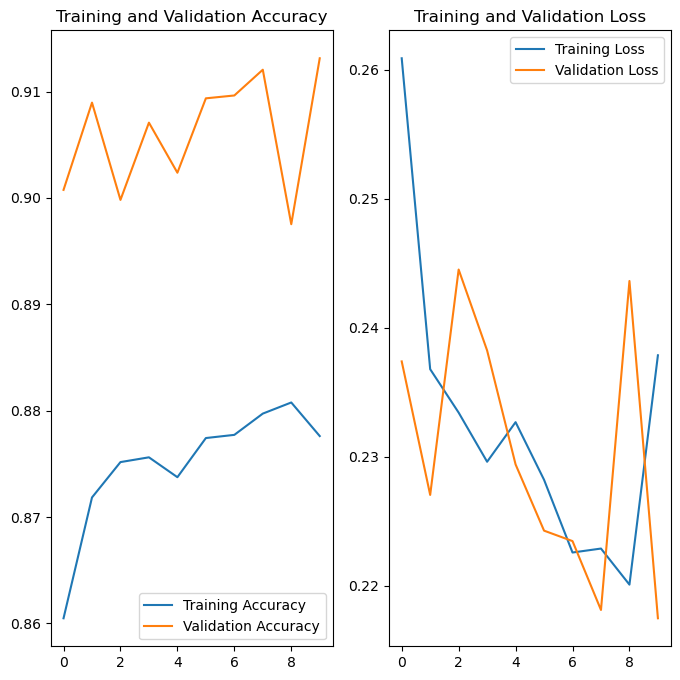

In [42]:
plot_results(history_model_weights)

In [43]:
model.save('with_classweights_10_epochs_augmentation_more.keras')

### To do some visualizations!

233/233 [==============================] - 5s 22ms/step


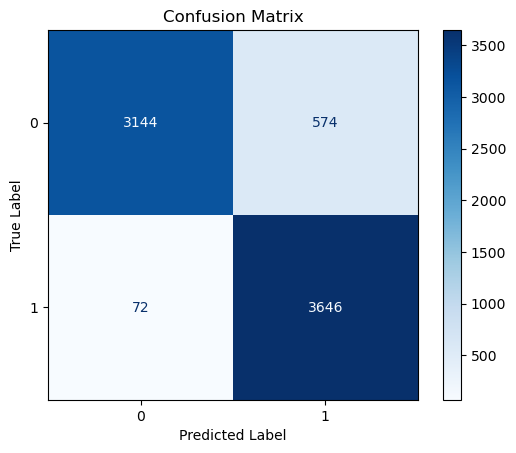

In [44]:
# True labels and predictions
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)  
y_pred = np.argmax(model.predict(validation_dataset), axis=1)       

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Customize plot (optional)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Model with bands RGB+NIR

In [ ]:
# Band 8 (NIR)
# Band 4 (Red)
# Band 3 (Green)
# Band 2 (Blue)

#Extract bands 2,3,4,8 from data
#Change input shape? Or can we just remove input shape and run the model again? 